In [2]:
import matplotlib.pyplot as plt
import sys
import numpy
import os
import glob
import fnmatch
import pandas as pd
import neurokit2 as nk
from datetime import datetime, timedelta, timezone

numpy.set_printoptions(threshold=sys.maxsize)
plt.rcParams["figure.figsize"] = (25,20)

### Functions to get start time

In [47]:
def convert_time(time_str):
    # Convert the string to a datetime object
    time_obj = datetime.strptime(time_str, '%I:%M:%S %p')
    # Convert the time to 24-hour format
    timestampo = timedelta(hours=time_obj.hour, minutes= time_obj.minute, seconds=time_obj.second)
    print(F"target: {timestampo}")

    return timestampo

def get_time_from_line(line):
    # Extract mm:ss part from the line
    time_str = line.split('Start Time: ')[1].strip()
    time_str = convert_time(time_str)
    return time_str

def find_index_in_dataframe(text_file, start_timestamp, Hz):
    # Read the text file and extract the mm:ss time
    target_time = None
    with open(text_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Start Time: '):
                time = get_time_from_line(line)
                if time:
                    target_time = time
                    break

    if target_time:
        # Find the index of the row with the target time
        start_time = start_timestamp
        start_time = timedelta(hours=start_time.hour ,minutes= start_time.minute, seconds=start_time.second)
        print(f"starting: {start_time}")
        print(f"diff: {(target_time - start_time).seconds}")
         
        time_diff = (target_time - start_time).seconds 
         
        
        index = 0 
        if  time_diff < 1800 : index = time_diff * Hz

        return index
    else:
        print("no target time")
        return None

## Load and get starting indexes

In [48]:
path_eda = "./dataset/P*/E4/EDA.csv"
path_ppg = "./dataset/P*/E4/BVP.csv"
path_acc = "./dataset/P*/EARBUDS/*imu-right.csv"

eda_all = []
ppg_all = [] 
acc_all = [] 

for filename in glob.glob(path_eda):
    eda_all.append(pd.read_csv(filename))

for filename in glob.glob(path_ppg):
    ppg_all.append(pd.read_csv(filename))

for filename in glob.glob(path_acc):
    acc_all.append(pd.read_csv(filename))


text_path = "./dataset/P*/VO2/Details.txt"
time_i_all = []
time_i_all_ppg = []
time_i_all_acc = []
for i, filename in enumerate(glob.glob(text_path)):
    time_i_all.append(find_index_in_dataframe(filename, datetime.fromtimestamp(int(float(eda_all[i].columns[0])), tz= timezone.utc), 4))
    time_i_all_ppg.append(find_index_in_dataframe(filename, datetime.fromtimestamp(int(float(ppg_all[i].columns[0])), tz= timezone.utc), 64))

    acc_start = acc_all[i].iloc[0,0]
    try:
        index = find_index_in_dataframe(filename, datetime.fromtimestamp(int(int(acc_start) / 1000), tz= timezone.utc), 100)
        time_i_all_acc.append(index)
    except:
        date_and_time = str(acc_all[i].iloc[0, 0]).split()
        d = date_and_time[0].split("-")
        d = [int(day) for day in d]
        t = date_and_time[1].split(":")
        t = [int(time) for time in t]
        earbud_start_time = datetime(d[0], d[1], d[2], hour=t[0], minute=t[1], second=t[2])
        time_i_all_acc.append(find_index_in_dataframe(filename, earbud_start_time, 100))

print(len(acc_all))

C:\Users\abrar\AppData\Local\Temp\ipykernel_18488\2827863268.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  acc_all.append(pd.read_csv(filename))
C:\Users\abrar\AppData\Local\Temp\ipykernel_18488\2827863268.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  acc_all.append(pd.read_csv(filename))


target: 16:58:50
starting: 16:57:44
diff: 66
target: 16:58:50
starting: 16:57:44
diff: 66
target: 16:58:50
starting: 16:53:50
diff: 300
target: 17:17:42
starting: 16:56:49
diff: 1253
target: 17:17:42
starting: 16:56:49
diff: 1253
target: 17:17:42
starting: 17:15:40
diff: 122
target: 16:20:26
starting: 16:08:13
diff: 733
target: 16:20:26
starting: 16:08:13
diff: 733
target: 16:20:26
starting: 16:25:30
diff: 86096
target: 18:15:48
starting: 17:48:17
diff: 1651
target: 18:15:48
starting: 17:48:17
diff: 1651
target: 18:15:48
starting: 18:01:51
diff: 837
target: 9:40:47
starting: 9:18:01
diff: 1366
target: 9:40:47
starting: 9:18:01
diff: 1366
target: 9:40:47
starting: 9:33:46
diff: 421
target: 10:37:54
starting: 10:25:43
diff: 731
target: 10:37:54
starting: 10:25:43
diff: 731
target: 10:37:54
starting: 10:34:54
diff: 180
target: 15:33:02
starting: 15:19:40
diff: 802
target: 15:33:02
starting: 15:19:40
diff: 802
target: 15:33:02
starting: 15:32:55
diff: 7
target: 18:00:31
starting: 17:40:35


In [49]:
print(time_i_all_acc)

[30000, 12200, 0, 83700, 42100, 18000, 700, 1800, 0, 98700, 74900, 0, 400, 0, 0, 123300, 0]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


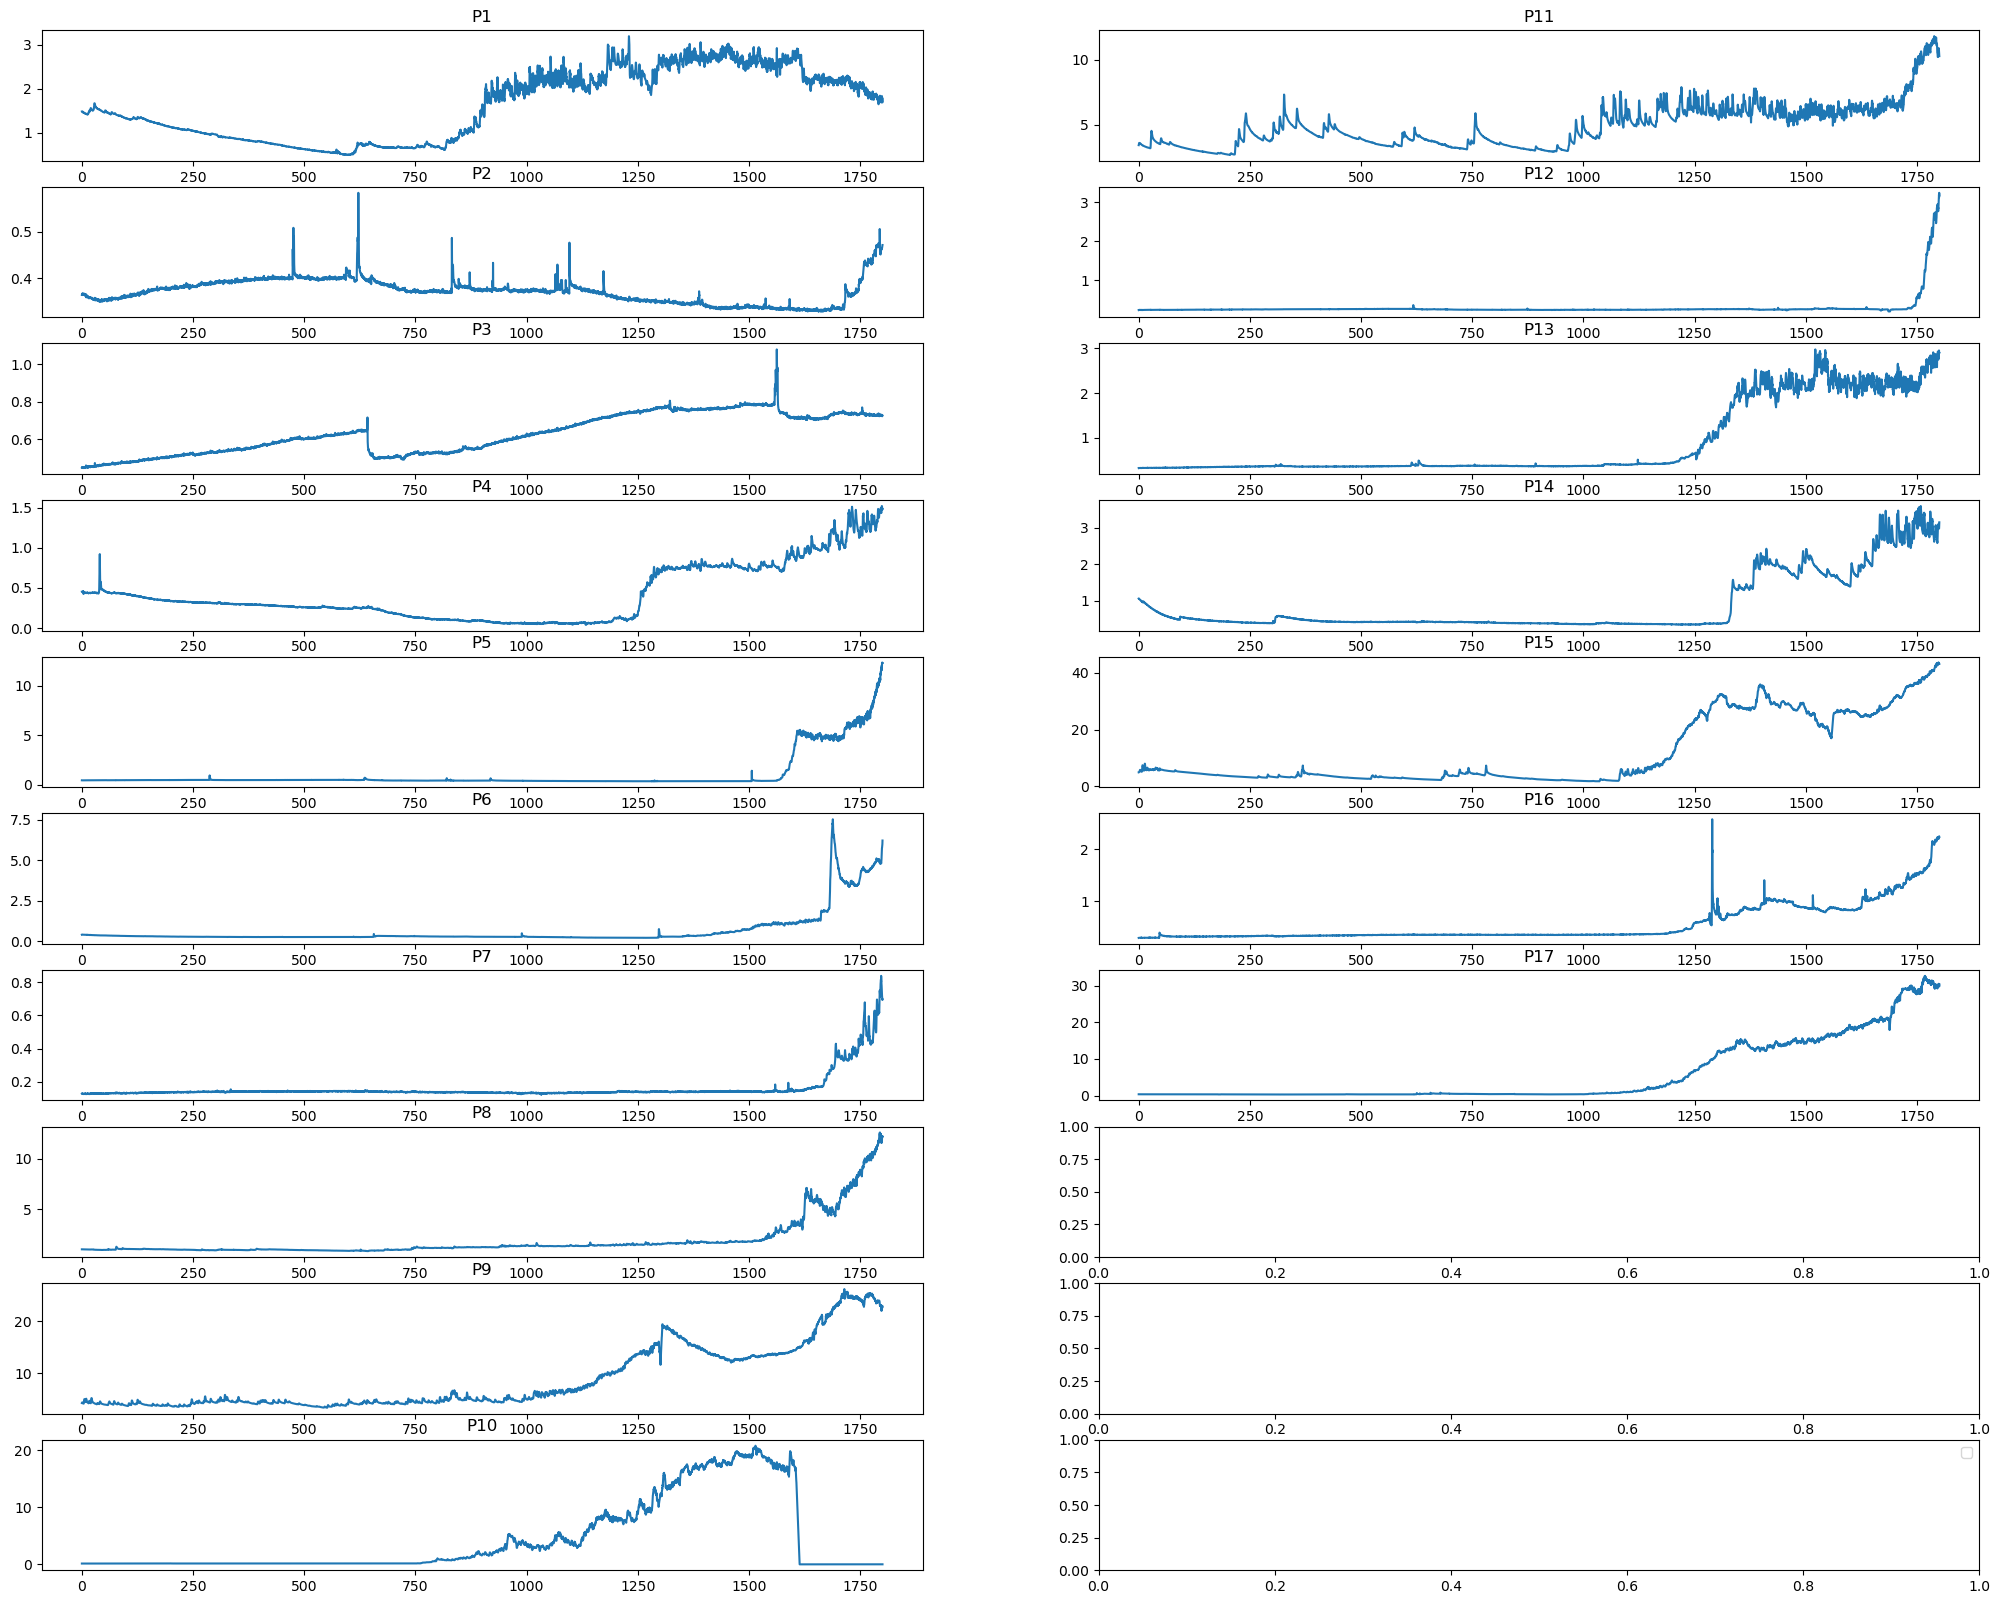

In [165]:
figure, axis = plt.subplots(10, 2) 
for i, eda_raw in enumerate(eda_all): # 7 and 14 prob
    total_sec = 1800
    sample_rate = 4
    start_index = time_i_all[i]
    end_index = start_index + (total_sec * sample_rate) #1800 * sample_rate) # 30 mins
    eda_signal = eda_raw.iloc[start_index:end_index, 0]
    # # eda_signal = nk.ecg_clean(eda_signal, sampling_rate=sample_rate, method='biosppy')
    # signals, info = nk.ecg_process(eda_signal, sampling_rate=sample_rate, method='neurokit') # (default): 0.5 Hz high-pass butterworth filter (order = 5), followed by powerline filtering (see signal_filter()). By default, powerline = 50

    # # Visualize
    # nk.ecg_plot(signals, info)
    # plt.plot(numpy.linspace(0, total_sec, total_sec * sample_rate), eda_signal)
    # axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, len(eda_signal) / 4, len(eda_signal)), eda_signal, label='original')
    axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, total_sec, total_sec * sample_rate), eda_signal, label='original')
    axis[i if i < 10 else i - 10,0 if i < 10 else 1].set_title('P' + str(i + 1))
    # axis[i].set_title('ecg ' + str(i))
plt.legend(loc='best')

## PPG

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


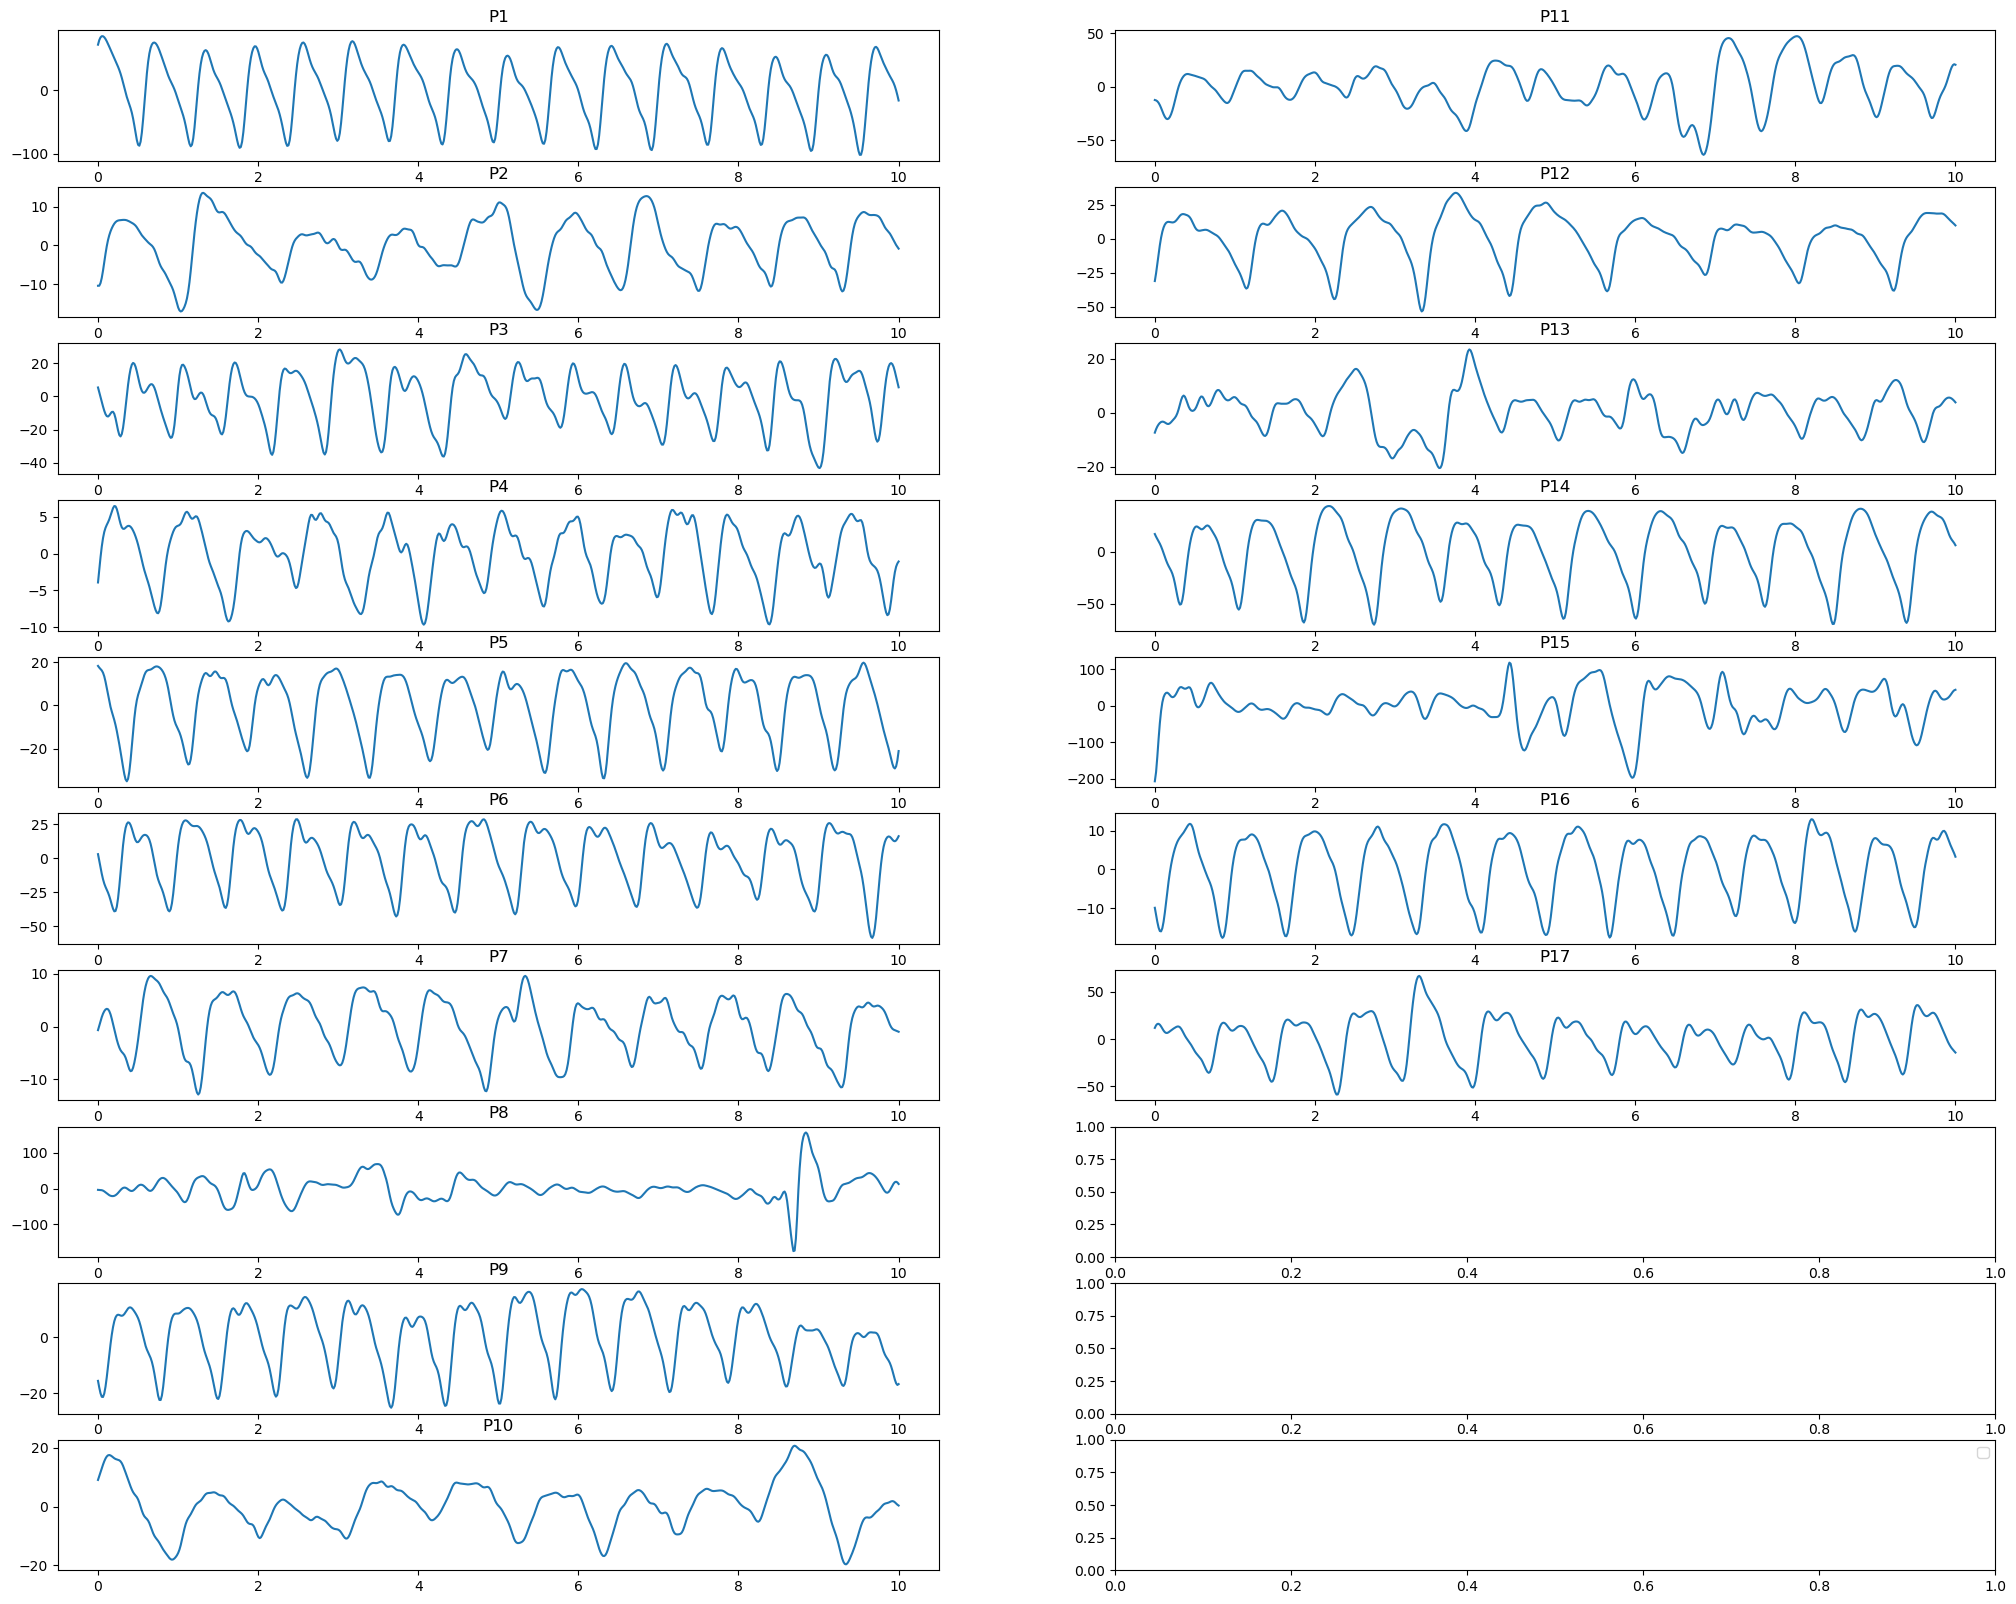

In [178]:
figure, axis = plt.subplots(10, 2) 
for i, ppg_raw in enumerate(ppg_all): # 7 and 14 prob
    total_sec = 10#800
    sample_rate = 64
    start_index = time_i_all_ppg[i] + 1500
    end_index = start_index + (total_sec * sample_rate) #1800 * sample_rate) # 30 mins
    ppg_signal = ppg_raw.iloc[start_index:end_index, 0]
    # # ppg_signal = nk.ecg_clean(ppg_signal, sampling_rate=sample_rate, method='biosppy')
    # signals, info = nk.ecg_process(ppg_signal, sampling_rate=sample_rate, method='neurokit') # (default): 0.5 Hz high-pass butterworth filter (order = 5), followed by powerline filtering (see signal_filter()). By default, powerline = 50

    # # Visualize
    # Full signal
    # axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, len(ppg_signal) / 4, len(ppg_signal)), ppg_signal, label='original')

    # 30 min signal
    axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, total_sec, total_sec * sample_rate), ppg_signal, label='original')

    # Set title of each subplot
    axis[i if i < 10 else i - 10,0 if i < 10 else 1].set_title('P' + str(i + 1))
    # axis[i].set_title('ecg ' + str(i))
plt.legend(loc='best')

## Acceleration Data 

In [50]:
acc_all[3]

,timestamp,ax,ay,az,gx,gy,gz
0,1637949711814,-10066,-5042,-11384,335,3,157
1,1637949711823,-10114,-5046,-11504,288,25,250
2,1637949711833,-10295,-5255,-11458,246,68,309
3,1637949711842,-10518,-5607,-11376,222,65,321
4,1637949711852,-10673,-5903,-11353,253,42,279
...,...,...,...,...,...,...,...
255969,1637952579912,13386,5795,2419,5114,-2153,2492
255970,1637952579922,13466,6400,2514,2161,-2629,2437
255971,1637952579931,13561,6708,2586,-1798,-3295,2702
255972,1637952579941,13665,6566,2666,-4757,-4206,3321


In [123]:
figure, axis = plt.subplots(10, 2) 
for i, acc_raw in enumerate(acc_all): # 7 and 14 prob
    # unit conversion
    acc_raw = acc_raw.iloc[:, 1:4].apply(lambda num: num / 1000)
    total_sec = 1800
    sample_rate = 100
    start_index = time_i_all_acc[i]
    end_index = start_index + (total_sec * sample_rate)
    # ============ Visualize ===============
    # Full signal 
    # acc_signal = acc_raw.iloc[:, 1:4]
    # axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, len(acc_signal) / sample_rate, len(acc_signal)), acc_signal, label='original')

    acc_signal = acc_raw.iloc[start_index:end_index, :] 

    length_diff = total_sec * sample_rate - len(acc_signal)
    if length_diff > 0:
        acc_signal = acc_signal.reindex(index=range(start_index, start_index + total_sec * sample_rate), fill_value=0)
    # 30 min signal unfiltered 
    # axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, total_sec, total_sec * sample_rate), acc_signal, label='original')

    # Filtered 
    # acc_signal = acc_raw.iloc[start_index:end_index, 0:3]
    moving_avg = acc_signal.rolling(window=32*60).mean(center=True)
    axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, total_sec, total_sec * sample_rate), moving_avg, label='original')

    # Set title of each subplot
    axis[i if i < 10 else i - 10,0 if i < 10 else 1].set_title('P' + str(i + 1))
    # axis[i].set_title('ecg ' + str(i))
plt.legend(loc='best')